# Training phase visualized examples

## Displaying an image to test the custom dataset

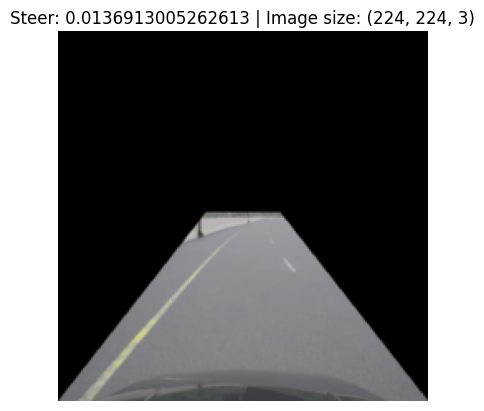

In [5]:
import matplotlib.pyplot as plt

# Convert the image into a numpy array
image_array = image.numpy()

# Transpose to get the shape [H, W, C]
# Always remember: PyTorch -> [C,H,W]  | Numpy & Matplotlib -> [H,W,C]
image_array = image_array.transpose(1, 2, 0)

plt.imshow(image_array)
plt.title(f"Steer: {steer} | Image size: {image_array.shape}")
plt.axis(False);

## ResNet - 18 model architecture after freezing layers

In [8]:
# Freeze all layers by default
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the 'layer4' and fully connected (fc) layer
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [9]:
import torchinfo
from torchinfo import summary

summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

### Trial forward pass to test model functionality

In [10]:
# 1. Get a batch of images and labels from the DataLoader
img_batch = next(iter(train_dataloader))['image'].to(device)
#throttle_batch = next(iter(train_dataloader))['throttle'].to(device)
steer_batch = next(iter(train_dataloader))['steer'].to(device)

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, steer_single = img_batch[0].unsqueeze(dim=0), steer_batch[0]
print(f"Single image shape: {img_single.shape}")
#print(f"Single throttle value: {throttle_single}")
print(f"Single steer value: {steer_single}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single)

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
#print(f"Output throttle: {pred[0,0]}")
print(f"Output steer: {pred}")

Single image shape: torch.Size([1, 3, 224, 224])
Single steer value: -0.0038694941904395

Output steer: tensor([[0.7043]], device='cuda:0')


# Setting up loss, scheduler and optimiser function

In [11]:
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.MSELoss()
# Optimizer: Different LR for different layers
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-5},  # Fine-tuning layer4
    {'params': model.fc.parameters(), 'lr': 1e-4}       # Fully connected layer
])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

### Trial train testing

In [12]:
import numpy as np

y= []
error = 0

for batch in train_dataloader:
    X = batch['image'].to(device)
    #throttle = batch['throttle'].to(device)
    labels = batch['steer'].to(device).float()
    #labels = torch.stack((throttle, steer), dim=1).to(device)                      
    #print(f"Image shape: {X[0]}")
    #print(f"Throttle shape: {throttle.shape}")
    #print(f"Steer shape: {steer.shape}")
    print(f"Labels shape: {labels.shape}")
    y_pred = model(X).squeeze(dim=1)
    print(f"Prediction shape: {y_pred.shape}")
    loss = loss_fn(y_pred, labels)
    #print(f"Loss: {loss.item()}")
    y.append(loss.item())
    error = ((labels-y_pred) ** 2).mean().item()
    print(error)
    error = ((labels-y_pred) ** 2).mean(axis=0)
    print(error)
    error = error.mean()
    print(f"Error: {error}")
    print(f"Y: {y}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break

Labels shape: torch.Size([64])
Prediction shape: torch.Size([64])
0.30506467819213867
tensor(0.3051, device='cuda:0', grad_fn=<MeanBackward1>)
Error: 0.30506467819213867
Y: [0.30506467819213867]


### Plotting a loss curve to check overfitting

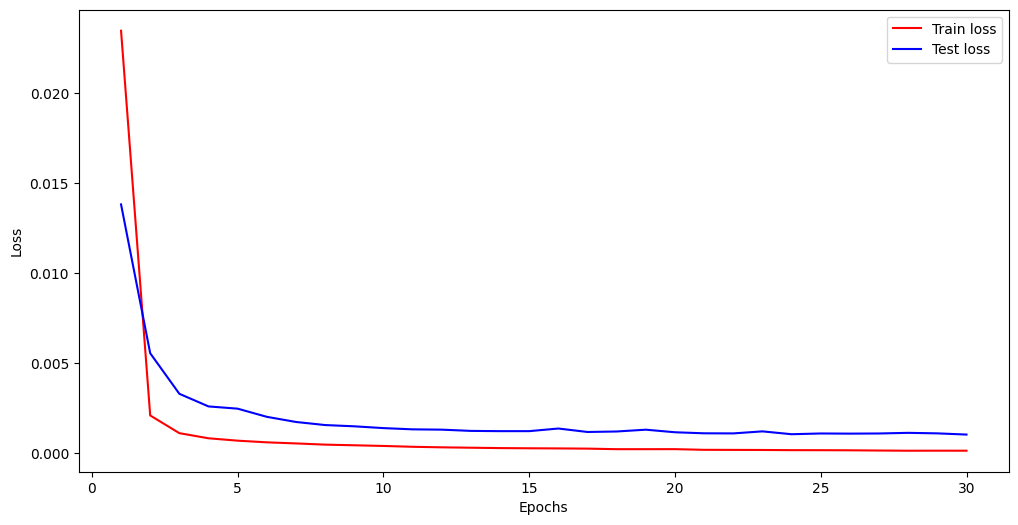

In [16]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(train_loss_np)+1), train_loss_np, label='Train loss', color='red')
plt.plot(range(1, len(test_loss_np)+1), test_loss_np, label='Test loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### Plotting the LR schedule plot

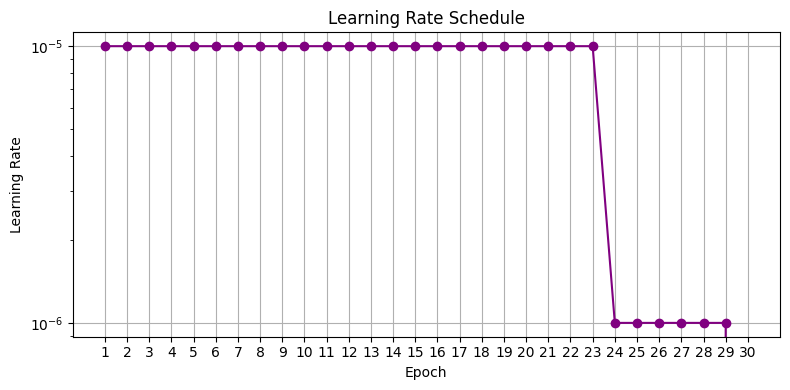

In [3]:
import matplotlib.pyplot as plt

# Learning rate for each of the 30 epochs
lrs = [
    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5,
    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5,
    1e-5, 1e-5, 1e-5, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 0.0
]
epochs = list(range(1, 31))

plt.figure(figsize=(8, 4))
plt.plot(epochs, lrs, marker='o', linestyle='-', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.xticks(epochs)
plt.yscale('log')  # because of the log-scale decay
plt.tight_layout()
plt.savefig('lr_schedule.png', dpi=600) 
plt.show()

### Train vs validation loss curve

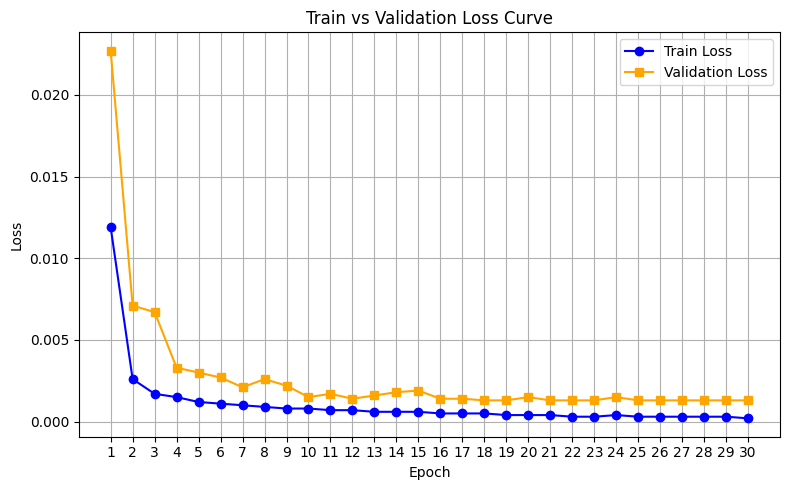

In [1]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 31))

# Train and test losses
train_loss = [
    0.0119, 0.0026, 0.0017, 0.0015, 0.0012, 0.0011, 0.0010, 0.0009, 0.0008, 0.0008,
    0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004,
    0.0004, 0.0003, 0.0003, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002
]

val_loss = [
    0.0227, 0.0071, 0.0067, 0.0033, 0.0030, 0.0027, 0.0021, 0.0026, 0.0022, 0.0015,
    0.0017, 0.0014, 0.0016, 0.0018, 0.0019, 0.0014, 0.0014, 0.0013, 0.0013, 0.0015,
    0.0013, 0.0013, 0.0013, 0.0015, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013
]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss Curve')
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig('train_test_loss.pdf', dpi=600)
plt.show()  # optional if you want to view it

# v5 model

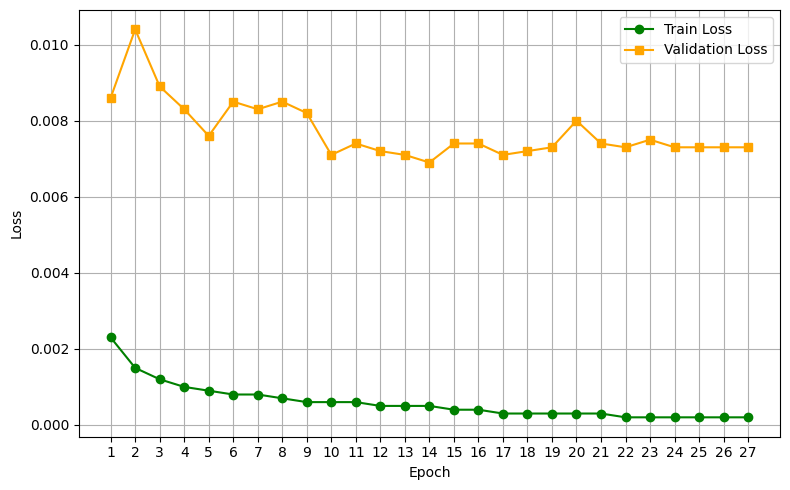

In [4]:
import matplotlib.pyplot as plt

epochs = list(range(1, 28))

train_loss = [
    0.0023, 0.0015, 0.0012, 0.0010, 0.0009, 0.0008, 0.0008, 0.0007, 0.0006, 0.0006,
    0.0006, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003,
    0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002
]

val_loss = [
    0.0086, 0.0104, 0.0089, 0.0083, 0.0076, 0.0085, 0.0083, 0.0085, 0.0082, 0.0071,
    0.0074, 0.0072, 0.0071, 0.0069, 0.0074, 0.0074, 0.0071, 0.0072, 0.0073, 0.0080,
    0.0074, 0.0073, 0.0075, 0.0073, 0.0073, 0.0073, 0.0073
]

lrs = [
    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5,
    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-6,
    1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 0.0, 0.0
]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='green', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('Train vs Validation Loss Curve for original mo')
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig('train_test_loss_v5.pdf', dpi=600)
plt.show()  # optional if you want to view it

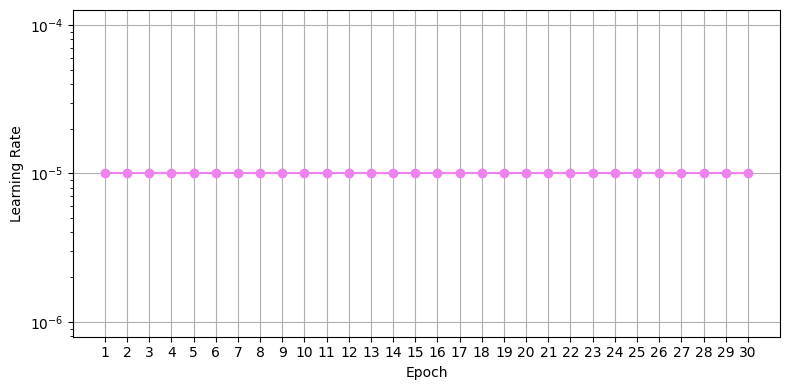

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, lrs, marker='o', linestyle='-', color='violet')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
# plt.title('Learning Rate Schedule')
plt.grid(True)
plt.xticks(epochs)
plt.yscale('log')  # because of the log-scale decay
plt.tight_layout()
plt.savefig('lr_schedule_v5.pdf', dpi=600) 
plt.show()

# v7 model

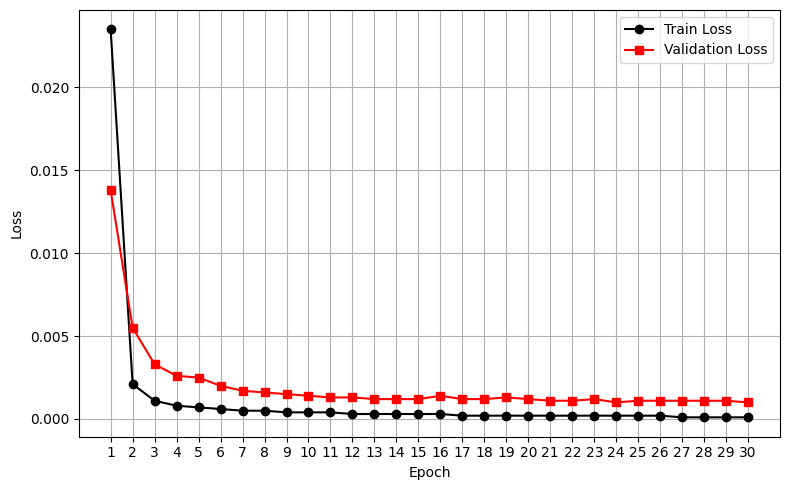

In [8]:
epochs = list(range(1, 31))

train_loss = [
    0.0235, 0.0021, 0.0011, 0.0008, 0.0007, 0.0006, 0.0005, 0.0005, 0.0004, 0.0004,
    0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002,
    0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001
]

val_loss = [
    0.0138, 0.0055, 0.0033, 0.0026, 0.0025, 0.0020, 0.0017, 0.0016, 0.0015, 0.0014,
    0.0013, 0.0013, 0.0012, 0.0012, 0.0012, 0.0014, 0.0012, 0.0012, 0.0013, 0.0012,
    0.0011, 0.0011, 0.0012, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010
]

lrs = [1e-5] * 30

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='black', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('Train vs Validation Loss Curve for original mo')
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig('train_test_loss_v7.pdf', dpi=600)
plt.show()  # optional if you want to view it

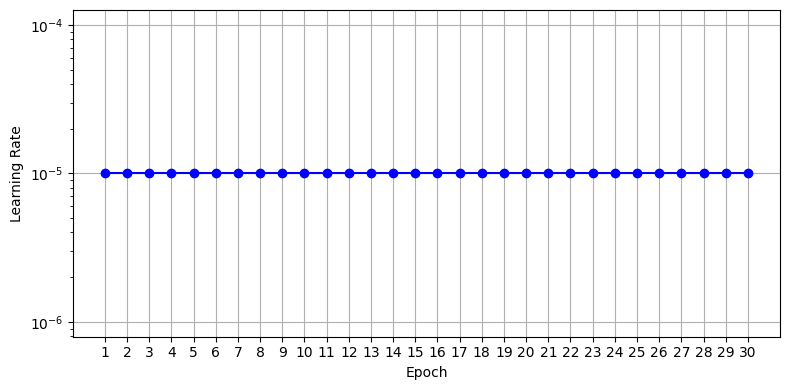

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, lrs, marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
#plt.title('Learning Rate Schedule')
plt.grid(True)
plt.xticks(epochs)
plt.yscale('log')  # because of the log-scale decay
plt.tight_layout()
plt.savefig('lr_schedule_v7.pdf', dpi=600) 
plt.show()